In [ ]:
!pip install deeprenewal
!pip install 'rpy2>=2.9.*,<3.*'
!R -e 'install.packages(c("forecast", "nnfor"), repos="https://cloud.r-project.org")'

In [2]:
import random
import os
import numpy as np
import mxnet as mx

def seed_everything():
    random.seed(42)
    np.random.seed(42)
    mx.random.seed(42)
    
seed_everything()

from deeprenewal import get_dataset
from gluonts.dataset.util import to_pandas
from deeprenewal import DeepRenewalEstimator
from deeprenewal import CrostonForecastPredictor
from deeprenewal import IntermittentEvaluator
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.piecewise_linear import PiecewiseLinearOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.model.r_forecast import RForecastPredictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.npts import NPTSPredictor
from gluonts.evaluation import Evaluator
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions 
import mxnet as mx
import ast
from tqdm import tqdm
from argparse import ArgumentParser
from gluonts.model.forecast import SampleForecast
from gluonts.model.predictor import Predictor
import pandas as pd
import joblib
import plotly.express as px
pd.set_option('display.max_columns', 500)

# Config

In [3]:
parser = ArgumentParser()
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

# add PROGRAM level args
parser.add_argument('--use-cuda', type=bool, default=True)
parser.add_argument('--log-gradients', type=bool, default=True)
parser.add_argument('--datasource', type=str, default="retail_dataset")
parser.add_argument('--model-save-dir', type=str, default="saved_models")

# Trainer specific args
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--learning-rate', type=float, default=1e-2)
parser.add_argument('--max-epochs', type=int, default=10)
parser.add_argument('--number-of-batches-per-epoch', type=int, default=100)
parser.add_argument('--clip-gradient', type=float, default=5.170127652392614)
parser.add_argument('--weight-decay', type=float, default=0.01)


# Model specific args
parser.add_argument('--context-length-multiplier', type=int, default=2)
parser.add_argument('--num-layers', type=int, default=2)
parser.add_argument('--num-cells', type=int, default=64)
parser.add_argument('--cell-type', type=str, default="lstm")
#p% are dropped and set to zero
parser.add_argument('--dropout-rate', type=float, default=0.3)
parser.add_argument('--use-feat-dynamic-real', type=bool, default=False)
parser.add_argument('--use-feat-static-cat', type=bool, default=False)
parser.add_argument('--use-feat-static-real', type=bool, default=False)
parser.add_argument('--scaling', type=bool, default=True)
parser.add_argument('--num-parallel-samples', type=int, default=100)
parser.add_argument('--num-lags', type=int, default=1)
#Only for Deep Renewal Processes
parser.add_argument('--forecast-type', type=str, default="hybrid")
#Only for Deep AR
parser.add_argument('--distr-output', type=str, default="student_t") #neg_binomial

args = parser.parse_args()
is_gpu = mx.context.num_gpus()>0

# Read in the dataset

In [4]:
dataset = get_dataset(args.datasource, regenerate=False)

In [5]:
prediction_length = dataset.metadata.prediction_length
freq = dataset.metadata.freq
cardinality = ast.literal_eval(dataset.metadata.feat_static_cat[0].cardinality)
train_ds = dataset.train
test_ds = dataset.test

# Baselines

## ETS

In [8]:
ets_predictor = RForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   method_name = 'ets', 
                                   )

ets_forecast = list(ets_predictor.predict(train_ds))

## Arima

In [9]:
arima_predictor = RForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   method_name = 'arima', 
                                   )

arima_forecast = list(arima_predictor.predict(train_ds))

## Croston

In [10]:
croston_predictor = CrostonForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   variant = 'original',
                                    no_of_params=2
                                   )

croston_forecast = list(croston_predictor.predict(train_ds))

## SBA

In [11]:
sba_predictor = CrostonForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   variant = 'sba',
                                    no_of_params=2
                                   )

sba_forecast = list(sba_predictor.predict(train_ds))

## SBJ

In [12]:
sbj_predictor = CrostonForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   variant = 'sbj',
                                    no_of_params=2
                                   )

sbj_forecast = list(sbj_predictor.predict(train_ds))

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:118: RuntimeWarning:

overflow encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:117: RuntimeWarning:

overflow encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:120: RuntimeWarning:

invalid value encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:120: RuntimeWarning:

invalid value encountered in true_divide

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:120: RuntimeWarning:

overflow encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:120: RuntimeWarning:

overflow encountered in multiply

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:118: RuntimeWarning:

invalid value encountered in double_scalars



## NPTS

In [30]:
npts_predictor = NPTSPredictor(freq=freq, prediction_length=prediction_length, context_length=300, kernel_type='uniform', use_seasonal_model=False)

npts_forecast = list(npts_predictor.predict(train_ds))

## DeepAR

In [19]:
# if args.distr_output=="neg_binomial":
#     distr = NegativeBinomialOutput()
# elif args.distr_output == "student_t":
#     distr = StudentTOutput()

distr = PiecewiseLinearOutput(7)

deep_ar_trainer = Trainer(ctx=mx.context.gpu() if is_gpu&args.use_cuda else mx.context.cpu(), 
                  batch_size=128,
                  learning_rate=1e-2,
                  epochs=20,
                  num_batches_per_epoch=args.number_of_batches_per_epoch,
                  clip_gradient=5.48481845049343,
                  weight_decay=0.001,
                  hybridize=True) #hybridize false for development

deep_ar_estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=prediction_length*2,
    num_layers=2,
    num_cells=128,
    cell_type='gru',
    dropout_rate=0.1,
    scaling=True,
    lags_seq=np.arange(1,1+1).tolist(),
    freq=freq,
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    use_feat_static_real=False,
    distr_output=distr,
    cardinality=None,#cardinality,
    trainer=deep_ar_trainer,
)
deep_ar_predictor = deep_ar_estimator.train(train_ds, test_ds)

100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.26it/s, epoch=1/20, avg_epoch_loss=5.12]
17it [00:03,  5.04it/s, epoch=1/20, validation_avg_epoch_loss=4.73]
100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s, epoch=2/20, avg_epoch_loss=4.36]
17it [00:03,  5.52it/s, epoch=2/20, validation_avg_epoch_loss=4.61]
100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s, epoch=3/20, avg_epoch_loss=4.84]
16it [00:02,  5.57it/s, epoch=3/20, validation_avg_epoch_loss=4.51]
100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s, epoch=4/20, avg_epoch_loss=4.16]
16it [00:03,  5.26it/s, epoch=4/20, validation_avg_epoch_loss=4.41]
100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.33it/s, epoch=5/20, avg_epoch_loss=4.32]
17it [00:03,  5.13it/s, epoch=5/20, validation_avg_epoch_loss=4.43]
100%|███████████████████████████████████████████████| 100/10

In [20]:
# save the trained model
os.makedirs(args.model_save_dir, exist_ok=True)
os.makedirs(Path(args.model_save_dir)/"deep_ar_baseline", exist_ok=True)
deep_ar_predictor.serialize(Path(args.model_save_dir)/"deep_ar_baseline")

In [5]:
# deep_ar_predictor = Predictor.deserialize(Path(args.model_save_dir)/"deep_ar_baseline")
print("Generating Deep AR forecasts.......")
deep_ar_forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds, predictor=deep_ar_predictor, num_samples=100
)
tss = list(tqdm(ts_it, total=len(test_ds)))
deep_ar_forecasts = list(tqdm(deep_ar_forecast_it, total=len(test_ds)))

 10%|███████▊                                                                     | 184/1822 [00:00<00:00, 1827.16it/s]

Generating Deep AR forecasts.......


100%|██████████████████████████████████████████████████████████████████████████████| 1822/1822 [00:44<00:00, 40.70it/s]


# DeepRenewal

In [8]:
trainer = Trainer(ctx=mx.context.gpu() if is_gpu&args.use_cuda else mx.context.cpu(), 
                  batch_size=args.batch_size,
                  learning_rate=args.learning_rate,
                  epochs=20,
                  num_batches_per_epoch=args.number_of_batches_per_epoch,
                  clip_gradient=args.clip_gradient,
                  weight_decay=args.weight_decay,
                  hybridize=True) #hybridize false for development

estimator = DeepRenewalEstimator(
    prediction_length=prediction_length,
    context_length=prediction_length*args.context_length_multiplier,
    num_layers=args.num_layers,
    num_cells=args.num_cells,
    cell_type=args.cell_type,
    dropout_rate=args.dropout_rate,
    scaling=True,
    lags_seq=np.arange(1,args.num_lags+1).tolist(),
    freq=freq,
    use_feat_dynamic_real=args.use_feat_dynamic_real,
    use_feat_static_cat=args.use_feat_static_cat,
    use_feat_static_real=args.use_feat_static_real,
    cardinality=cardinality if args.use_feat_static_cat else None,
    trainer=trainer,
)
predictor = estimator.train(train_ds, test_ds)

100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s, epoch=1/20, avg_epoch_loss=6.13]
66it [00:12,  5.27it/s, epoch=1/20, validation_avg_epoch_loss=6.12]
100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s, epoch=2/20, avg_epoch_loss=6.11]
69it [00:12,  5.41it/s, epoch=2/20, validation_avg_epoch_loss=6.16]
100%|████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.47it/s, epoch=3/20, avg_epoch_loss=6.1]
67it [00:13,  5.02it/s, epoch=3/20, validation_avg_epoch_loss=6.16]
100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s, epoch=4/20, avg_epoch_loss=6.06]
66it [00:13,  5.01it/s, epoch=4/20, validation_avg_epoch_loss=6.09]
100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.45it/s, epoch=5/20, avg_epoch_loss=6.09]
65it [00:18,  3.50it/s, epoch=5/20, validation_avg_epoch_loss=6.08]
100%|███████████████████████████████████████████████| 100/10

In [9]:
# save the trained model
os.makedirs(args.model_save_dir, exist_ok=True)
os.makedirs(Path(args.model_save_dir)/"deeprenewal", exist_ok=True)
predictor.serialize(Path(args.model_save_dir)/"deeprenewal")

In [24]:
# print("Generating DeepRenewal forecasts.......")
# predictor = Predictor.deserialize(Path(args.model_save_dir)/"deeprenewal")
deep_renewal_flat_forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds, predictor=predictor, num_samples=100
)
# tss = list(tqdm(ts_it, total=len(test_ds)))
deep_renewal_flat_forecasts = list(tqdm(deep_renewal_flat_forecast_it, total=len(test_ds)))

#Deep Renewal Exact
predictor.forecast_generator.forecast_type = "exact"
deep_renewal_exact_forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds, predictor=predictor, num_samples=100
)
deep_renewal_exact_forecasts = list(tqdm(deep_renewal_exact_forecast_it, total=len(test_ds)))
# #Deep Renewal Hybrid
predictor.forecast_generator.forecast_type = "hybrid"
deep_renewal_hybrid_forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds, predictor=predictor, num_samples=100
)
deep_renewal_hybrid_forecasts = list(tqdm(deep_renewal_hybrid_forecast_it, total=len(test_ds)))

100%|██████████████████████████████████████████████████████████████████████████████| 1822/1822 [01:58<00:00, 15.43it/s]


# Evaluation

### Saving Generated Forecasts

In [27]:
joblib.dump({
    "tss":tss,
    "ets":ets_forecast,
    "arima": arima_forecast,
    "croston": croston_forecast,
    "sba": sba_forecast,
    "sbj": sbj_forecast,
    "npts":npts_forecast,
    "deep_ar": deep_ar_forecasts,
    "deep_renewal_flat": deep_renewal_flat_forecasts,
    "deep_renewal_exact":deep_renewal_exact_forecasts,
    "deep_renewal_hybrid": deep_renewal_hybrid_forecasts
}, "tmp/forecast_dict.sav")

['tmp/forecast_dict.sav']

### Loading Saved Forecasts

In [32]:
forecast_dict = joblib.load("../tmp/forecast_dict.sav")

tss = forecast_dict['tss']
ets_forecast = forecast_dict['ets']
arima_forecast = forecast_dict['arima']
croston_forecast = forecast_dict['croston']
sba_forecast = forecast_dict['sba']
sbj_forecast = forecast_dict['sbj']
npts_forecast = forecast_dict['npts']
deep_ar_forecasts = forecast_dict['deep_ar']
deep_renewal_flat_forecasts = forecast_dict['deep_renewal_flat']
deep_renewal_exact_forecasts = forecast_dict['deep_renewal_exact']
deep_renewal_hybrid_forecasts = forecast_dict['deep_renewal_hybrid']

### Calculating the Metrics

#### n steps ahead

In [33]:
evaluator = IntermittentEvaluator(quantiles=[0.25,0.5,0.75], median=True, calculate_spec=False, round_integer=True)
#DeepAR
deep_ar_agg_metrics, deep_ar_item_metrics = evaluator(
    iter(tss), iter(deep_ar_forecasts), num_series=len(test_ds)
)
#Croston
croston_agg_metrics, croston_item_metrics = evaluator(
    iter(tss), iter(croston_forecast), num_series=len(test_ds)
)
#SBA
sba_agg_metrics, sba_item_metrics = evaluator(
    iter(tss), iter(sba_forecast), num_series=len(test_ds)
)
#SBJ
sbj_agg_metrics, sbj_item_metrics = evaluator(
    iter(tss), iter(sbj_forecast), num_series=len(test_ds)
)
#NPTS
npts_agg_metrics, npts_item_metrics = evaluator(
    iter(tss), iter(npts_forecast), num_series=len(test_ds)
)
#ETS
ets_agg_metrics, ets_item_metrics = evaluator(
    iter(tss), iter(ets_forecast), num_series=len(test_ds)
)
#Arima
arima_agg_metrics, arima_item_metrics = evaluator(
    iter(tss), iter(arima_forecast), num_series=len(test_ds)
)
#DeepRenewal Flat
deep_renewal_flat_agg_metrics, deep_renewal_flat_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_flat_forecasts), num_series=len(test_ds)
)
#Deep Renewal Exact
deep_renewal_exact_agg_metrics, deep_renewal_exact_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_exact_forecasts), num_series=len(test_ds)
)
#Deep Renewal Hybrid
deep_renewal_hybrid_agg_metrics, deep_renewal_hybrid_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_hybrid_forecasts), num_series=len(test_ds)
)

deep_ar_agg_metrics['method'] = "DeepAR"
croston_agg_metrics['method'] = "Croston"
sba_agg_metrics['method'] = "SBA"
sbj_agg_metrics['method'] = "SBJ"
npts_agg_metrics['method'] = "NPTS"
arima_agg_metrics['method'] = "ARIMA"
ets_agg_metrics['method'] = "ETS"
deep_renewal_flat_agg_metrics['method'] = "DeepRenewal Flat"
deep_renewal_exact_agg_metrics['method'] = "DeepRenewal Exact"
deep_renewal_hybrid_agg_metrics['method'] = "DeepRenewal Hybrid"

Running evaluation:   0%|                                                                     | 0/1822 [00:00<?, ?it/s]D:\miniconda3\envs\timeseries\lib\site-packages\deeprenewal\_evaluator.py:230: RuntimeWarning:

divide by zero encountered in true_divide

D:\miniconda3\envs\timeseries\lib\site-packages\deeprenewal\_evaluator.py:273: RuntimeWarning:

divide by zero encountered in double_scalars

D:\miniconda3\envs\timeseries\lib\site-packages\deeprenewal\_evaluator.py:275: RuntimeWarning:

divide by zero encountered in double_scalars

Running evaluation: 100%|█████████████████████████████████████████████████████████| 1822/1822 [00:13<00:00, 132.77it/s]
D:\miniconda3\envs\timeseries\lib\site-packages\pandas\core\dtypes\cast.py:1507: UserWarning:


Running evaluation: 100%|█████████████████████████████████████████████████████████| 1822/1822 [00:13<00:00, 135.37it/s]


In [34]:
result_df = pd.DataFrame([deep_ar_agg_metrics,
                          croston_agg_metrics,
             sba_agg_metrics,
             sbj_agg_metrics,
             npts_agg_metrics,
                          arima_agg_metrics, 
                          ets_agg_metrics, 
                          deep_renewal_flat_agg_metrics, 
                          deep_renewal_exact_agg_metrics,
                          deep_renewal_hybrid_agg_metrics])

In [35]:
result_df.to_clipboard()

In [36]:
result_df[['method','MSE','MAPE','MAAPE']]

,method,MSE,MAPE,MAAPE
0,DeepAR,1634.493963,0.498365,0.718491
1,Croston,1621.312224,0.651231,0.631866
2,SBA,1641.360494,0.615323,0.635411
3,SBJ,1649.959230,0.628954,0.638445
4,NPTS,1770.325129,0.487850,0.735898
5,ARIMA,1546.229376,0.753744,0.628593
6,ETS,1556.074503,0.789137,0.632657
7,DeepRenewal Flat,1873.671212,0.429234,0.673749
8,DeepRenewal Exact,1888.273692,0.501533,0.785269
9,DeepRenewal Hybrid,1862.711545,0.394138,0.628899


In [37]:
result_df[['method',"QuantileLoss[0.25]","QuantileLoss[0.5]","QuantileLoss[0.75]","mean_wQuantileLoss"]]

,method,QuantileLoss[0.25],QuantileLoss[0.5],QuantileLoss[0.75],mean_wQuantileLoss
0,DeepAR,378217.182178,679862.764344,8.083363e+05,0.812562
1,Croston,664896.932264,791880.385754,9.188638e+05,1.034258
2,SBA,623338.101090,776084.551921,9.288310e+05,1.013627
3,SBJ,627880.775397,779758.618797,9.316365e+05,1.018426
4,NPTS,380956.000000,725255.000000,9.351025e+05,0.888705
5,ARIMA,598779.297692,784662.741175,9.579808e+05,1.019360
6,ETS,622502.778932,796128.399976,9.578084e+05,1.034605
7,DeepRenewal Flat,383524.400735,764167.863827,1.047170e+06,0.955554
8,DeepRenewal Exact,382825.500000,765640.000000,1.141210e+06,0.996832
9,DeepRenewal Hybrid,389981.225288,761474.496596,1.069187e+06,0.966778


#### One Step Ahead

In [24]:
tss = [t.iloc[0] for t in tss]
for forecasts in [ets_forecast, arima_forecast, croston_forecast, sba_forecast, sbj_forecast, npts_forecast, deep_ar_forecasts, deep_renewal_flat_forecasts, deep_renewal_exact_forecasts, deep_renewal_hybrid_forecasts ]:
    for f in forecasts:
        f.samples = f.samples[:,0].reshape(-1,1)

In [25]:
evaluator = IntermittentEvaluator(quantiles=[0.25,0.5,0.75], median=True, calculate_spec=False, round_integer=True)
#DeepAR
deep_ar_agg_metrics, deep_ar_item_metrics = evaluator(
    iter(tss), iter(deep_ar_forecasts), num_series=len(test_ds)
)
#Croston
croston_agg_metrics, croston_item_metrics = evaluator(
    iter(tss), iter(croston_forecast), num_series=len(test_ds)
)
#SBA
sba_agg_metrics, sba_item_metrics = evaluator(
    iter(tss), iter(sba_forecast), num_series=len(test_ds)
)
#SBJ
sbj_agg_metrics, sbj_item_metrics = evaluator(
    iter(tss), iter(sbj_forecast), num_series=len(test_ds)
)
#NPTS
npts_agg_metrics, npts_item_metrics = evaluator(
    iter(tss), iter(npts_forecast), num_series=len(test_ds)
)
#ETS
ets_agg_metrics, ets_item_metrics = evaluator(
    iter(tss), iter(ets_forecast), num_series=len(test_ds)
)
#Arima
arima_agg_metrics, arima_item_metrics = evaluator(
    iter(tss), iter(arima_forecast), num_series=len(test_ds)
)
#DeepRenewal Flat
deep_renewal_flat_agg_metrics, deep_renewal_flat_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_flat_forecasts), num_series=len(test_ds)
)
#Deep Renewal Exact
deep_renewal_exact_agg_metrics, deep_renewal_exact_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_exact_forecasts), num_series=len(test_ds)
)
#Deep Renewal Hybrid
deep_renewal_hybrid_agg_metrics, deep_renewal_hybrid_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_hybrid_forecasts), num_series=len(test_ds)
)

deep_ar_agg_metrics['method'] = "DeepAR"
croston_agg_metrics['method'] = "Croston"
sba_agg_metrics['method'] = "SBA"
sbj_agg_metrics['method'] = "SBJ"
npts_agg_metrics['method'] = "NPTS"
arima_agg_metrics['method'] = "ARIMA"
ets_agg_metrics['method'] = "ETS"
deep_renewal_flat_agg_metrics['method'] = "DeepRenewal Flat"
deep_renewal_exact_agg_metrics['method'] = "DeepRenewal Exact"
deep_renewal_hybrid_agg_metrics['method'] = "DeepRenewal Hybrid"

Running evaluation:   0%|                                                                     | 0/1822 [00:00<?, ?it/s]D:\miniconda3\envs\timeseries\lib\site-packages\deeprenewal\_evaluator.py:230: RuntimeWarning:

divide by zero encountered in true_divide

D:\miniconda3\envs\timeseries\lib\site-packages\deeprenewal\_evaluator.py:273: RuntimeWarning:

divide by zero encountered in double_scalars

D:\miniconda3\envs\timeseries\lib\site-packages\deeprenewal\_evaluator.py:275: RuntimeWarning:

divide by zero encountered in double_scalars

Running evaluation: 100%|█████████████████████████████████████████████████████████| 1822/1822 [00:13<00:00, 138.46it/s]
D:\miniconda3\envs\timeseries\lib\site-packages\pandas\core\dtypes\cast.py:1507: UserWarning:


Running evaluation: 100%|█████████████████████████████████████████████████████████| 1822/1822 [00:12<00:00, 146.78it/s]
D:\miniconda3\envs\timeseries\lib\site-packages\deeprenewal\_evaluator.py:344: VisibleDeprecationWarning:

Creating an nda

In [28]:
result_df = pd.DataFrame([deep_ar_agg_metrics,
                          croston_agg_metrics,
             sba_agg_metrics,
             sbj_agg_metrics,
             npts_agg_metrics,
                          arima_agg_metrics, 
                          ets_agg_metrics, 
                          deep_renewal_flat_agg_metrics, 
                          deep_renewal_exact_agg_metrics,
                          deep_renewal_hybrid_agg_metrics])

In [30]:
result_df[['method','MSE','MAPE','MAAPE']]

,method,MSE,MAPE,MAAPE
0,DeepAR,1634.493963,0.498365,0.718491
1,Croston,516.873765,0.752304,0.660499
2,SBA,507.467618,0.694000,0.657246
3,SBJ,514.519759,0.725875,0.661535
4,NPTS,488.804061,0.394000,0.694379
5,ARIMA,415.664654,0.695836,0.675822
6,ETS,403.114709,0.704450,0.679753
7,DeepRenewal Flat,551.348307,0.333927,0.681971
8,DeepRenewal Exact,559.606490,0.389691,0.776875
9,DeepRenewal Hybrid,489.372597,0.295060,0.559431


In [31]:
result_df[['method',"QuantileLoss[0.25]","QuantileLoss[0.5]","QuantileLoss[0.75]","mean_wQuantileLoss"]]

,method,QuantileLoss[0.25],QuantileLoss[0.5],QuantileLoss[0.75],mean_wQuantileLoss
0,DeepAR,378217.182178,679862.764344,808336.348224,0.812562
1,Croston,15608.855003,15877.302528,16145.750054,1.162576
2,SBA,14621.079639,15550.116840,16479.154040,1.138619
3,SBJ,14731.114603,15637.879818,16544.645034,1.145045
4,NPTS,6736.000000,12841.000000,16856.500000,0.889251
5,ARIMA,12316.658933,15921.235477,19710.513791,1.170301
6,ETS,12314.266014,15880.810305,19378.907186,1.161162
7,DeepRenewal Flat,6855.931182,13885.263009,18810.347246,0.964789
8,DeepRenewal Exact,6832.500000,13654.000000,16515.000000,0.902586
9,DeepRenewal Hybrid,7457.952184,14029.338172,16277.337775,0.921201


In [27]:
result_df.to_clipboard()

In [10]:
# joblib.dump([deep_ar_agg_metrics,
#                           croston_agg_metrics,
#              sba_agg_metrics,
#              sbj_agg_metrics,
#              npts_agg_metrics,
#                           arima_agg_metrics, 
#                           ets_agg_metrics, 
#                           deep_renewal_flat_agg_metrics, 
#                           deep_renewal_exact_agg_metrics,
#                           deep_renewal_hybrid_agg_metrics], "metrics.pkl")

['metrics.pkl']

In [13]:
# [deep_ar_agg_metrics,
#                           croston_agg_metrics,
#              sba_agg_metrics,
#              sbj_agg_metrics,
#              npts_agg_metrics,
#                           arima_agg_metrics, 
#                           ets_agg_metrics, 
#                           deep_renewal_flat_agg_metrics, 
#                           deep_renewal_exact_agg_metrics,
#                           deep_renewal_hybrid_agg_metrics] = joblib.load("metrics.pkl")

### Visualization

#### Loading Saved Forecasts

In [38]:
forecast_dict = joblib.load("../tmp/forecast_dict.sav")

tss = forecast_dict['tss']
ets_forecast = forecast_dict['ets']
arima_forecast = forecast_dict['arima']
croston_forecast = forecast_dict['croston']
sba_forecast = forecast_dict['sba']
sbj_forecast = forecast_dict['sbj']
npts_forecast = forecast_dict['npts']
deep_ar_forecasts = forecast_dict['deep_ar']
deep_renewal_flat_forecasts = forecast_dict['deep_renewal_flat']
deep_renewal_exact_forecasts = forecast_dict['deep_renewal_exact']
deep_renewal_hybrid_forecasts = forecast_dict['deep_renewal_hybrid']

In [39]:
import matplotlib.pyplot as plt
import random

In [40]:
def plot_prob_forecasts(ts_entry, forecast_entry, title):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    title = title if forecast_entry.item_id is None else title+"|"+forecast_entry.item_id
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.title(title)
    plt.show()

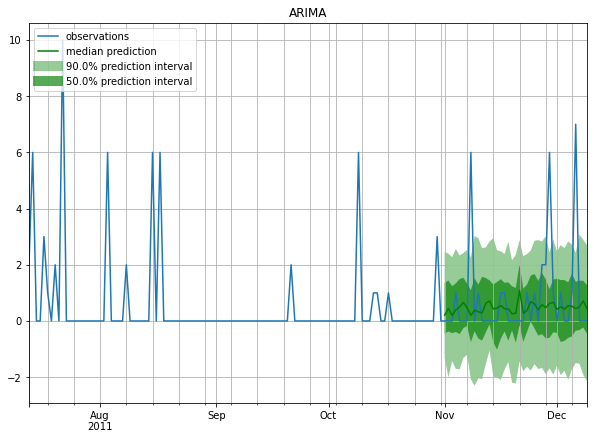

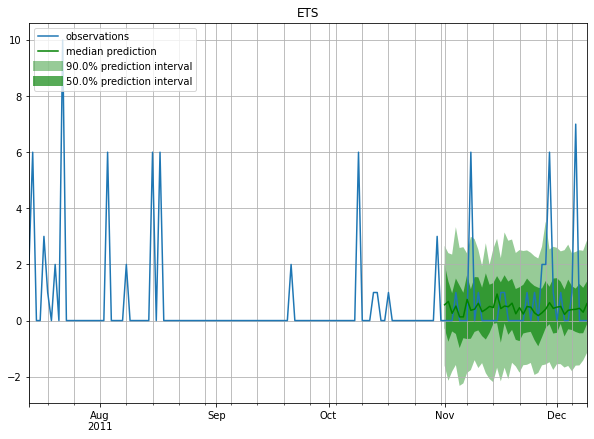

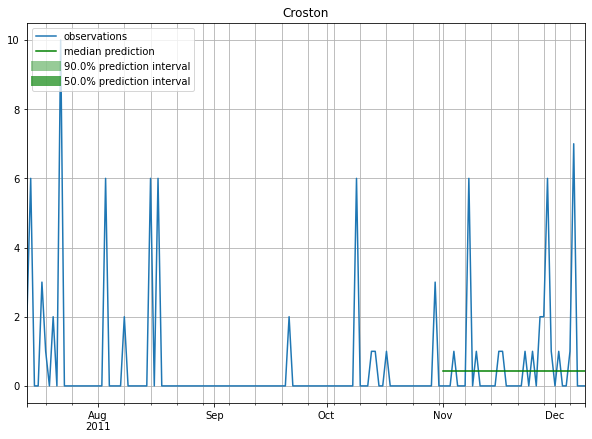

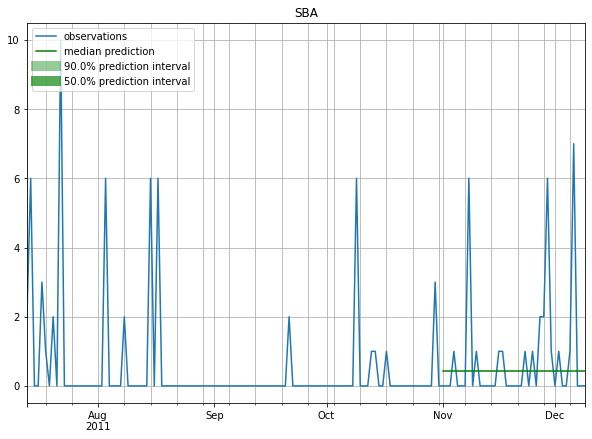

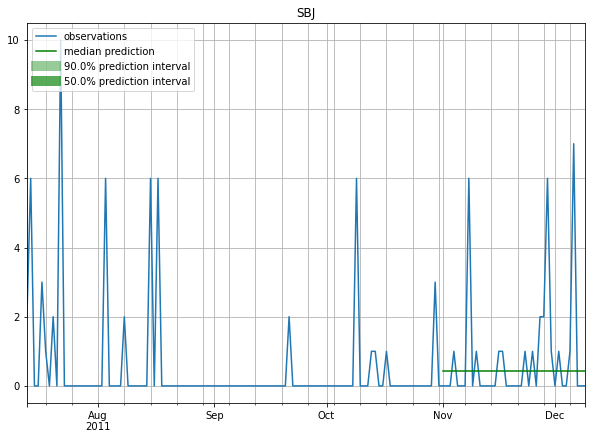

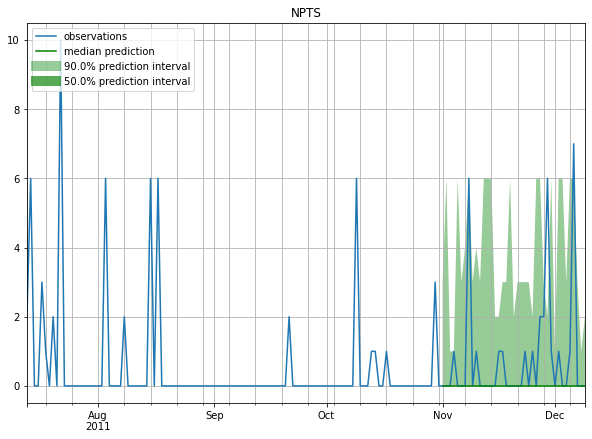

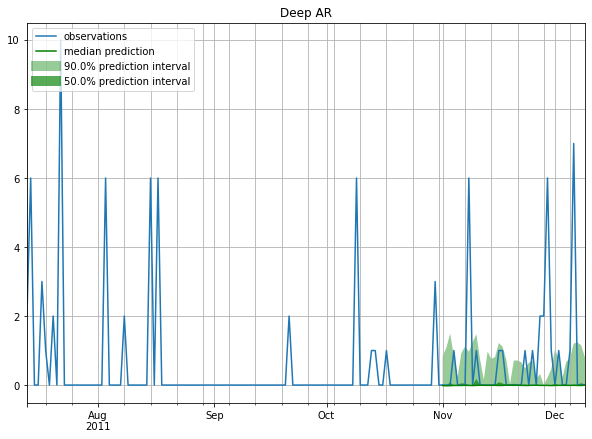

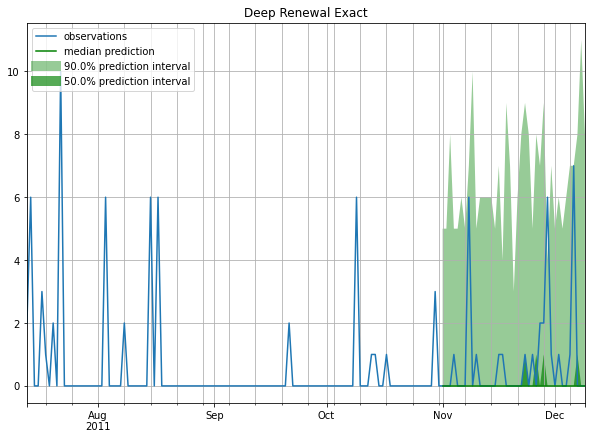

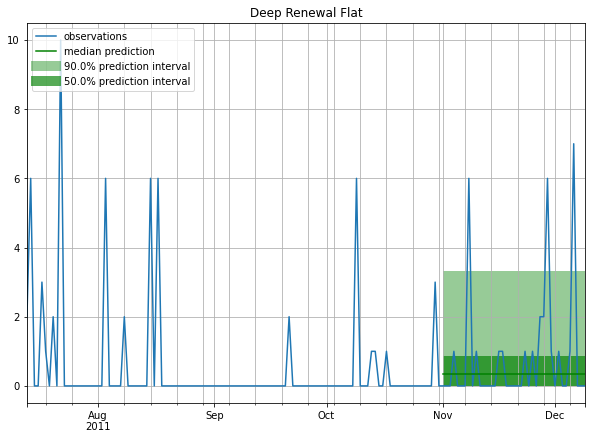

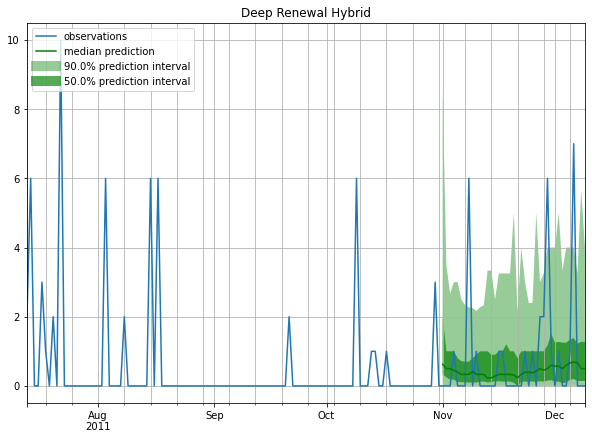

In [85]:
idx = 56
forecasts = [arima_forecast, ets_forecast, croston_forecast, sba_forecast, sbj_forecast, npts_forecast, deep_ar_forecasts, deep_renewal_exact_forecasts, deep_renewal_flat_forecasts, deep_renewal_hybrid_forecasts]
names = ["ARIMA","ETS","Croston","SBA","SBJ","NPTS","Deep AR","Deep Renewal Exact","Deep Renewal Flat","Deep Renewal Hybrid"]

for forecast, name in zip(forecasts, names):
    plot_prob_forecasts(tss[idx], forecast[idx],name)

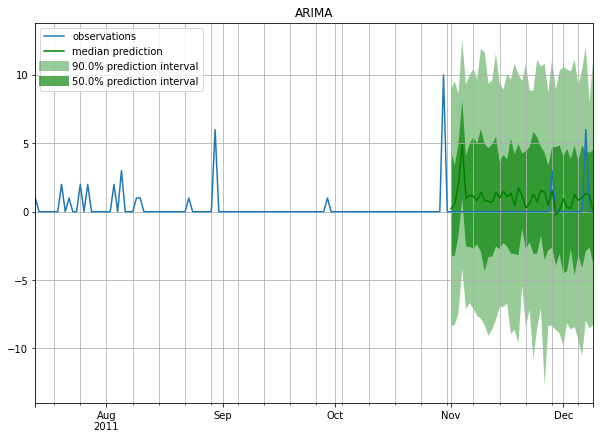

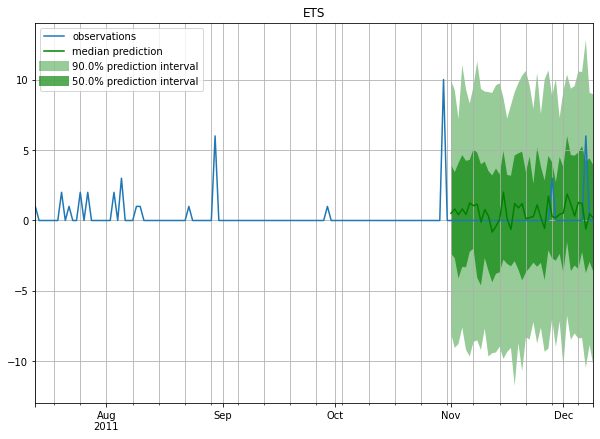

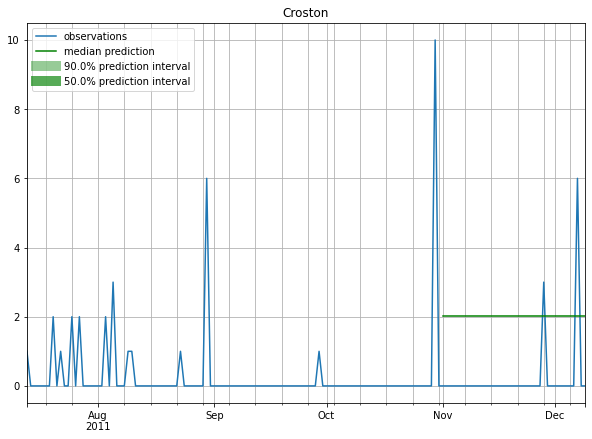

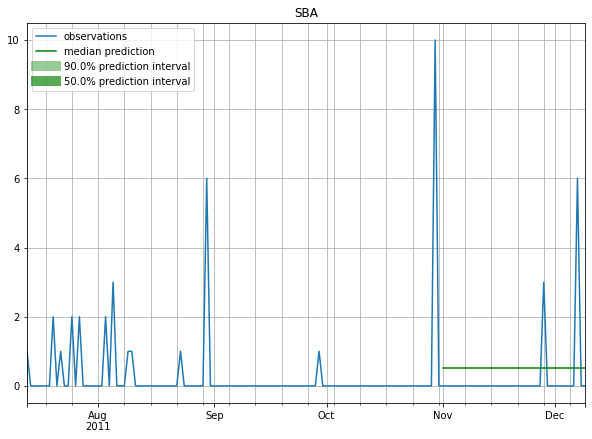

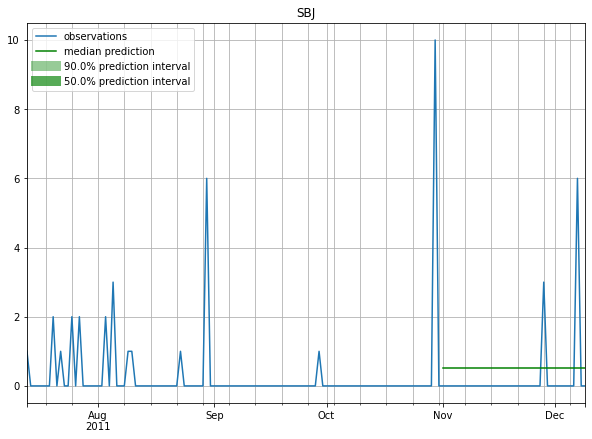

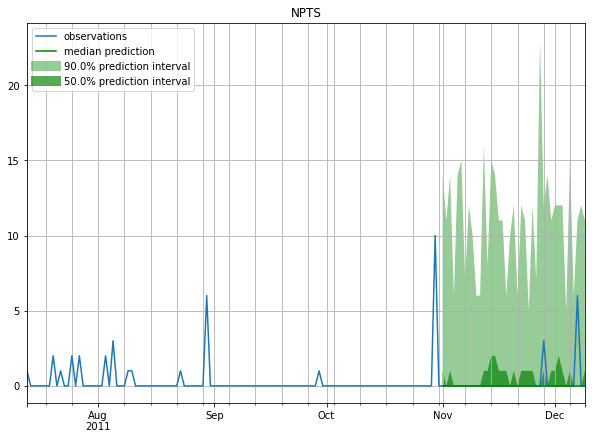

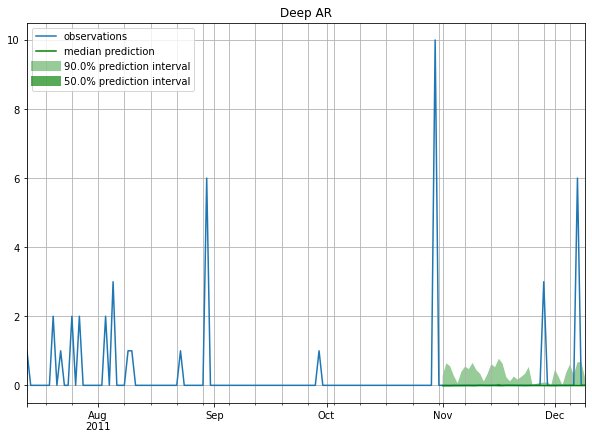

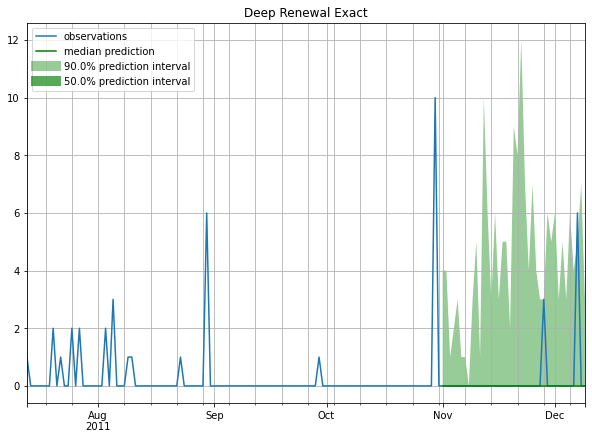

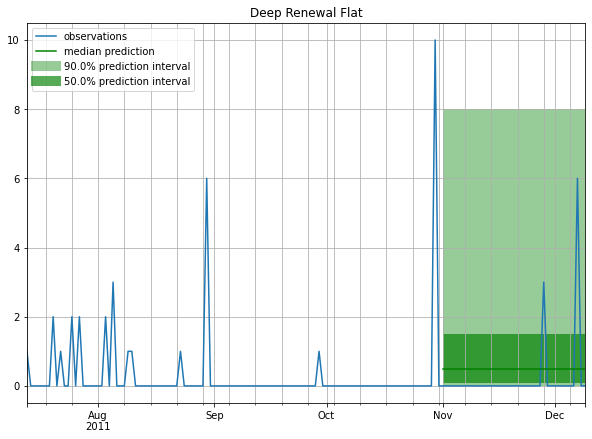

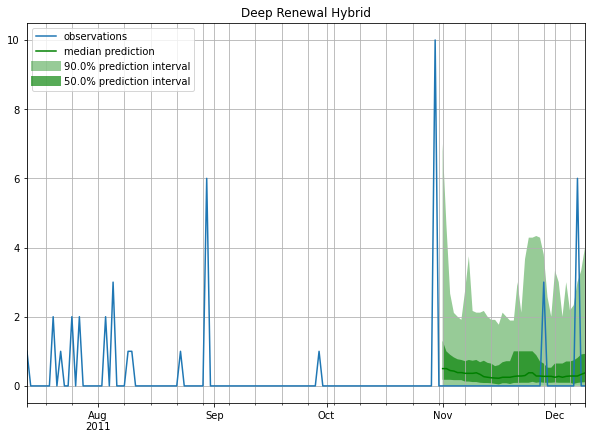

In [80]:
idx = 245
forecasts = [arima_forecast, ets_forecast, croston_forecast, sba_forecast, sbj_forecast, npts_forecast, deep_ar_forecasts, deep_renewal_exact_forecasts, deep_renewal_flat_forecasts, deep_renewal_hybrid_forecasts]
names = ["ARIMA","ETS","Croston","SBA","SBJ","NPTS","Deep AR","Deep Renewal Exact","Deep Renewal Flat","Deep Renewal Hybrid"]

for forecast, name in zip(forecasts, names):
    plot_prob_forecasts(tss[idx], forecast[idx],name)

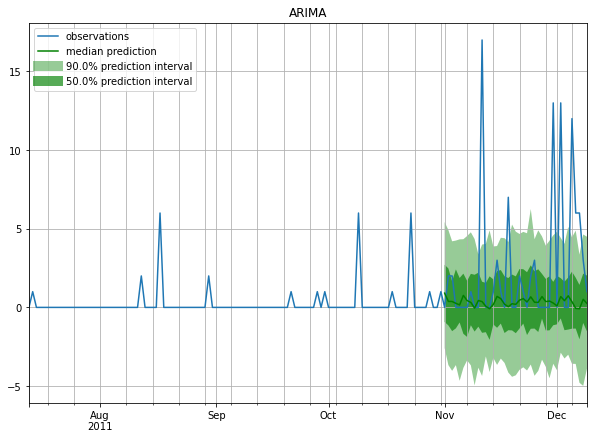

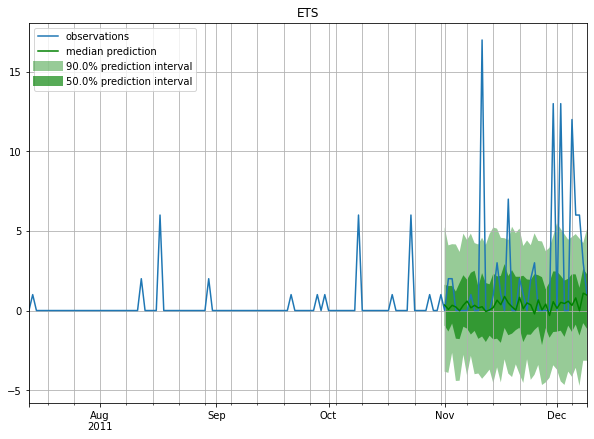

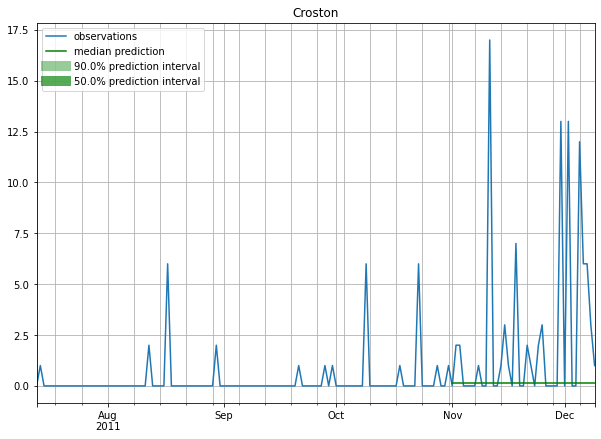

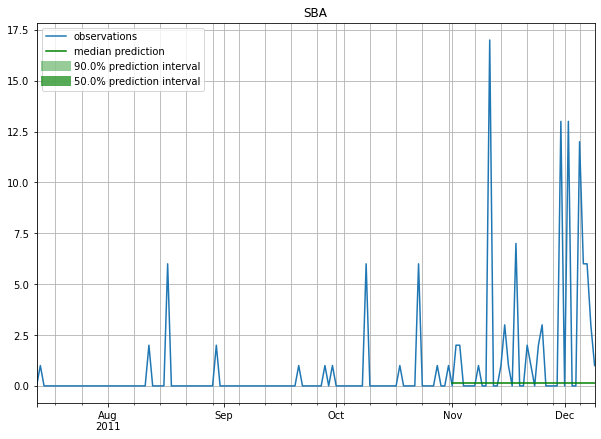

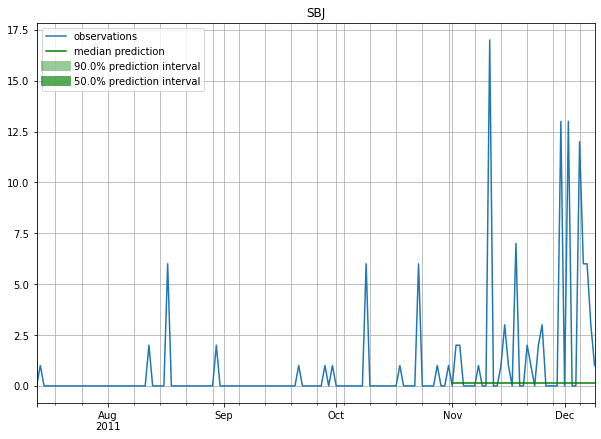

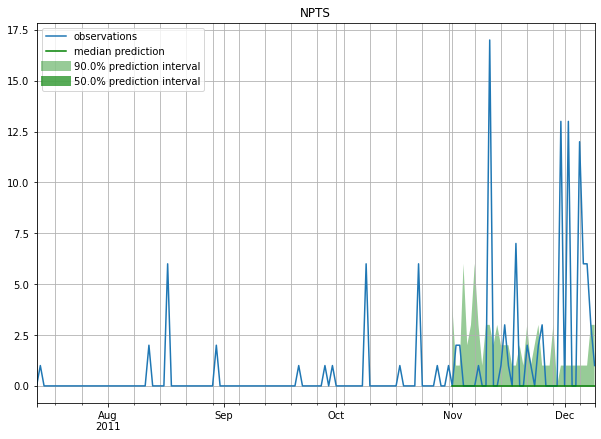

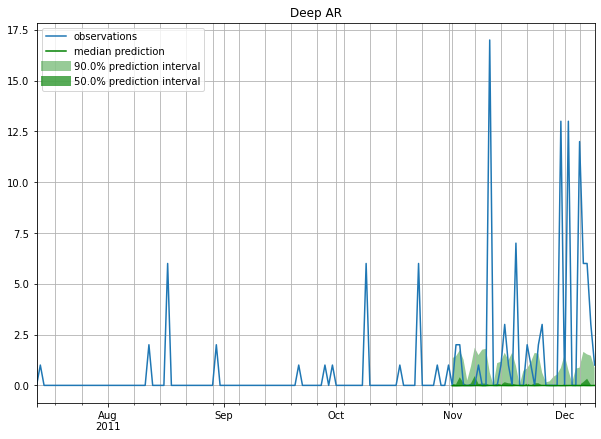

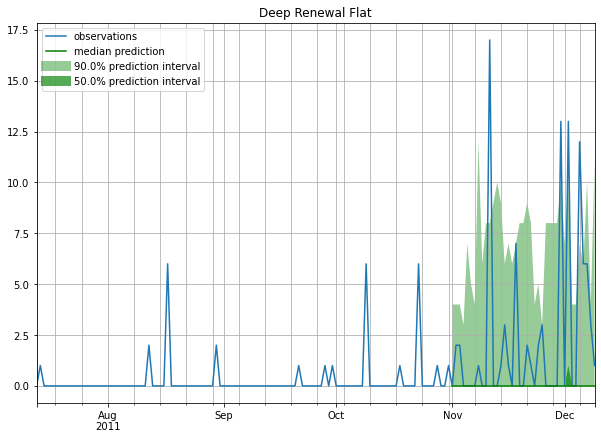

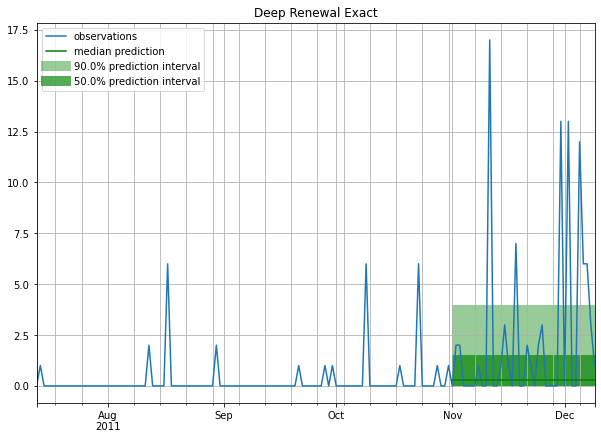

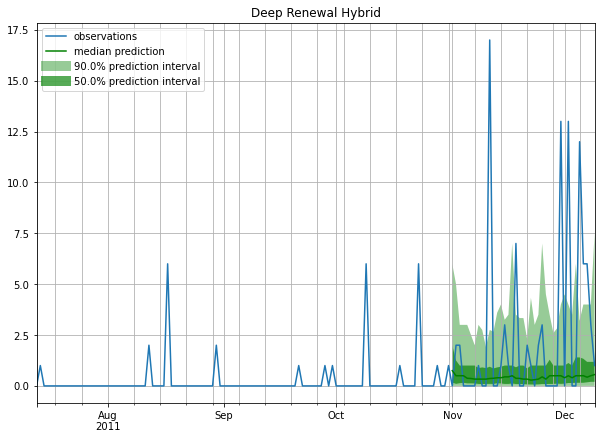

In [81]:
idx = 325
forecasts = [arima_forecast, ets_forecast, croston_forecast, sba_forecast, sbj_forecast, npts_forecast, deep_ar_forecasts, deep_renewal_exact_forecasts, deep_renewal_flat_forecasts, deep_renewal_hybrid_forecasts]
names = ["ARIMA","ETS","Croston","SBA","SBJ","NPTS","Deep AR","Deep Renewal Flat","Deep Renewal Exact","Deep Renewal Hybrid"]

for forecast, name in zip(forecasts, names):
    plot_prob_forecasts(tss[idx], forecast[idx],name)

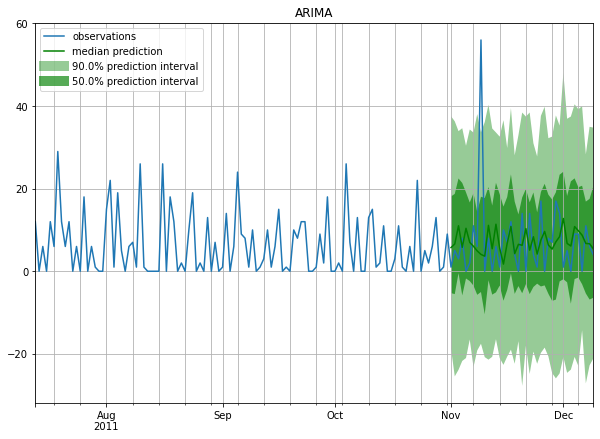

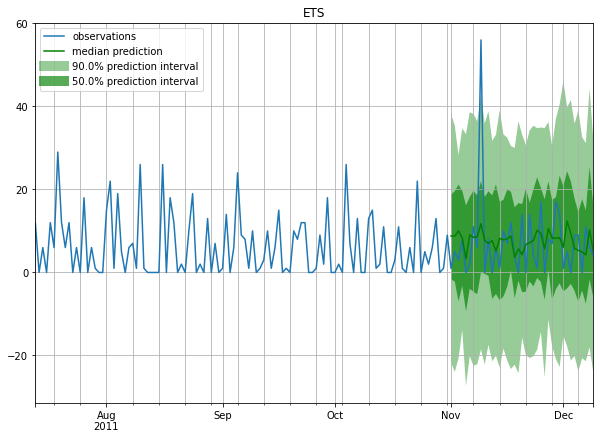

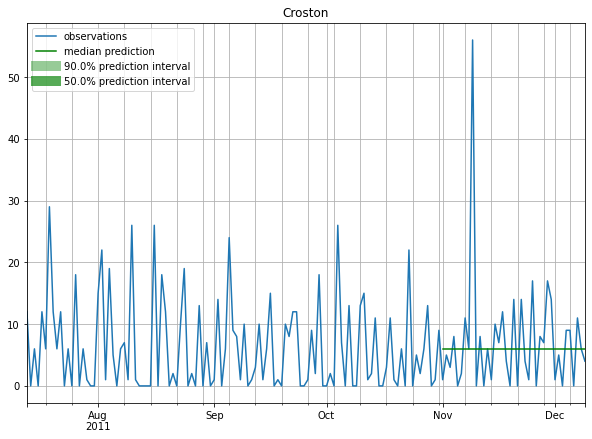

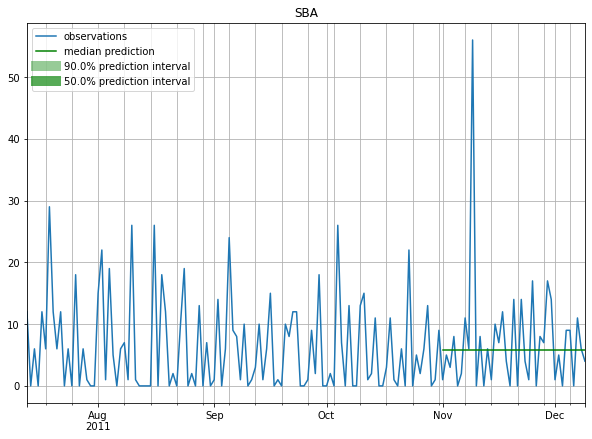

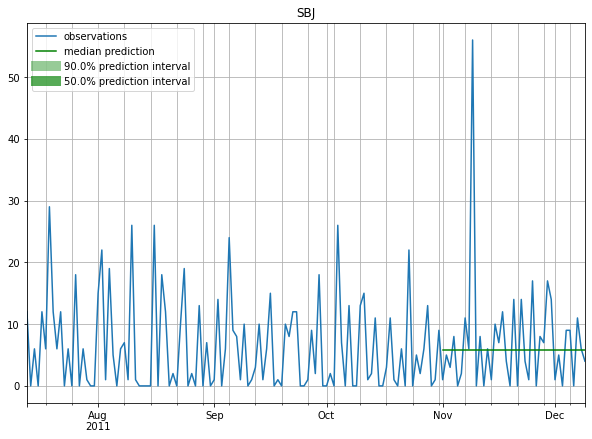

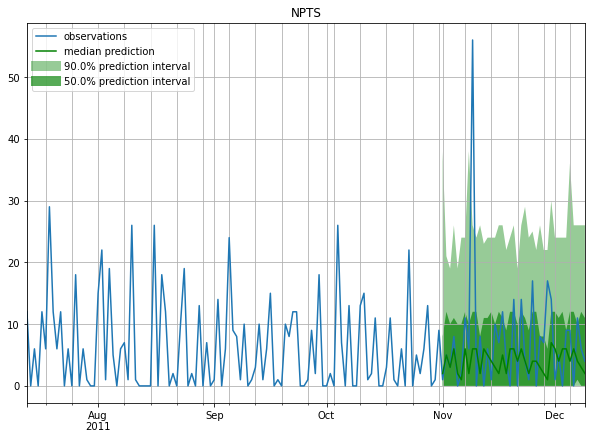

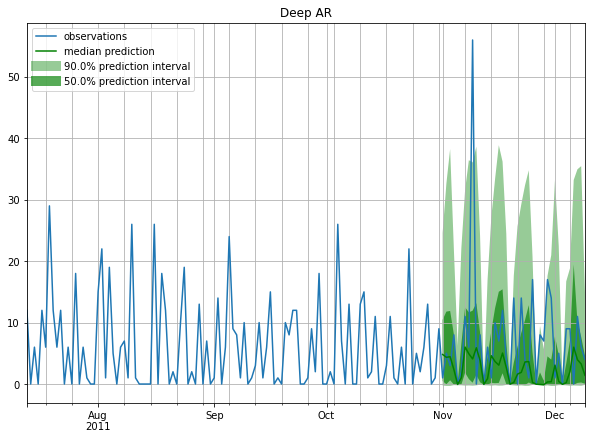

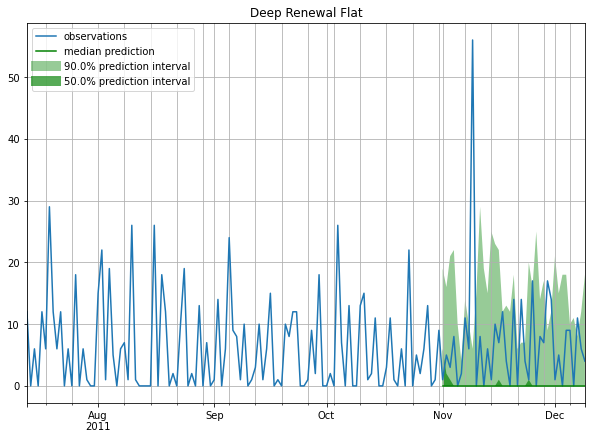

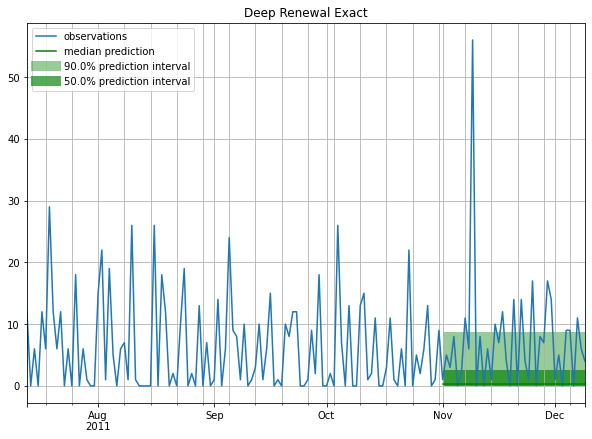

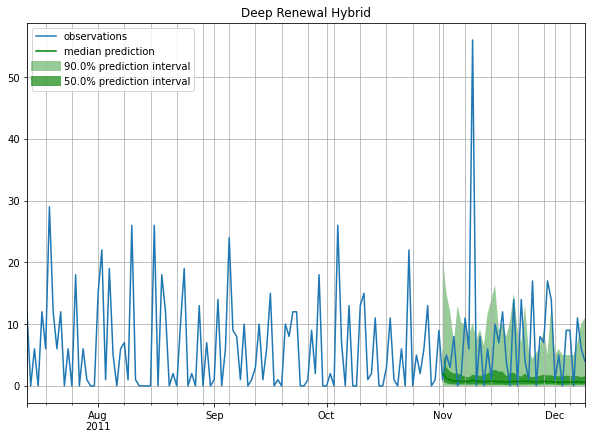

In [82]:
idx = 145
forecasts = [arima_forecast, ets_forecast, croston_forecast, sba_forecast, sbj_forecast, npts_forecast, deep_ar_forecasts, deep_renewal_exact_forecasts, deep_renewal_flat_forecasts, deep_renewal_hybrid_forecasts]
names = ["ARIMA","ETS","Croston","SBA","SBJ","NPTS","Deep AR","Deep Renewal Flat","Deep Renewal Exact","Deep Renewal Hybrid"]

for forecast, name in zip(forecasts, names):
    plot_prob_forecasts(tss[idx], forecast[idx],name)